Calculating mean and std of all RGB-values: 100%|██████████| 502/502 [00:00<00:00, 511.79it/s]


Mean:  tensor([0.0119, 0.0149, 0.0272]) , Std:  tensor([0.0140, 0.0176, 0.0247])
Loaded model iResNet_50_DSWT_actNormTrue_priorTrue_elu_from_toy_data_derived


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----Reconstruct and Visualize 5 sample images-----
Original Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


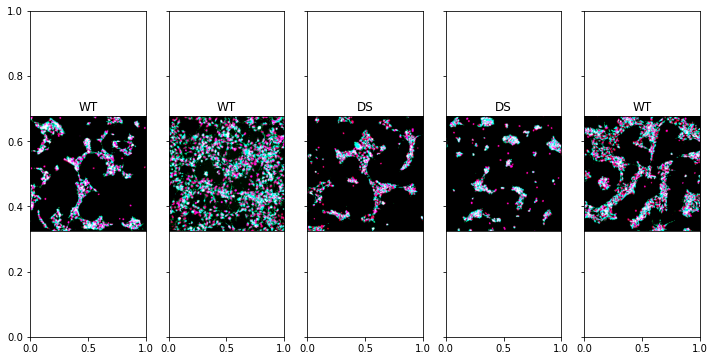

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


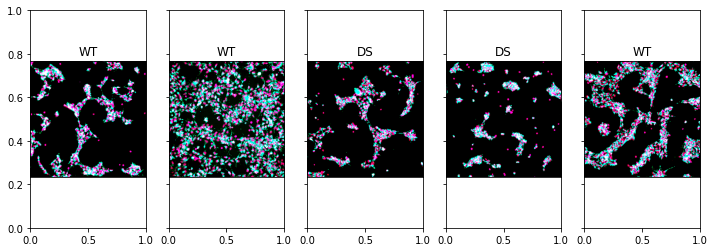

Evaluating model...: 100%|██████████| 218/218 [00:18<00:00, 11.74it/s]


Done
Got 164/218 with accuracy 75.229%
[[94 15]
 [39 70]]
TN:  94 FP:  15 
FN:  39 TP:  70
              precision    recall  f1-score   support

          DS       0.71      0.86      0.78       109
          WT       0.82      0.64      0.72       109

    accuracy                           0.75       218
   macro avg       0.77      0.75      0.75       218
weighted avg       0.77      0.75      0.75       218

std_pos:  0.08681439295432224 ; std_neg:  0.03423351018419248
mean_pos:  0.5310478174905164 ; mean_neg:  0.4591923700560124
Z'-Factor:  -4.053809034402689


Extracting latent space embeddings from test classes...: 100%|██████████| 218/218 [00:20<00:00, 10.65it/s]


Done
Plotting latent space embeddings...
PCA:


TSNE 2D:


c:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Done


Extracting latent space embeddings from train classes...: 100%|██████████| 502/502 [00:48<00:00, 10.41it/s]


Done
Converting lists to a pandas dataframe...
    This might take a while and consume a lot of memory...
Done


Calculating mean latent space embedding by predicted labels...: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Done


Calculating mean latent space embedding by original labels...: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Done


Generating counterfactuals: 100%|██████████| 218/218 [07:51<00:00,  2.16s/it]

Done.


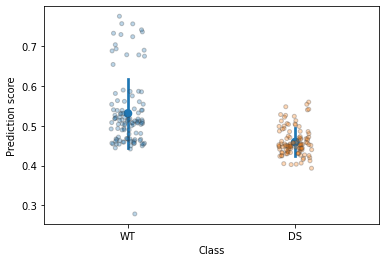

In [1]:
from __future__ import print_function, division
if __name__ == '__main__':
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.optim import lr_scheduler
    from torchvision import datasets, transforms
    from sklearn.metrics import confusion_matrix, classification_report
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import copy
    import time, random
    import itertools
    import gc
    from tqdm import tqdm
    from cnns.helper.nn_prepro_utils import get_mean_and_std, get_model_type, get_init_batch, plot_loss, plot_accuracy, train_iResNet, reconstruct_and_print_sample_images, try_make_dir
    from cnns.helper.nn_counterfactual import extract_z_space, plot_z_space, lists_to_dataframe, get_cluster_means, generate_counterfactuals, reconstruct_encoded_sample, interpolate_encoded_samples, make_gif

    # Set the path to the dataset
    pic_folder_path = "S:/mdc_work/mdc_leigh/images/alessandros_data/224"     # the folder, where the images are stored in different resolutions
    # Use mean and std of the train set for normalization of all inputs?
    use_normalize = True

    # Set the model_type
    # 'ResNext50', 'ResNet50' or 'iResNet'
    #model_type = "ResNext50"
    model_type = "iResNet"
    #model_type = "ResNet50"
    custom_iResNet_classifier = True

    load_pretrained_model = True
    train = False
    reset_custom_linear_classifier = False
    evaluation = True
    counterfactual_generation = True

    output_model_path = "S:/BA/models/iResNet50_2048z_512ch"
    output_model_name = "iResNet_50_DSWT_actNormTrue_priorTrue_elu_from_toy_data_derived"


    input_model_path = output_model_path
    input_model_name = output_model_name
    
    ###################

    data_dir = pic_folder_path
    os.chdir(data_dir)

    # ----------- Hyperparameters -----------
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters for training
    learning_rate = 0.0005 #0.1,  0.0005 
    batch_size = 20 #20 #15 #30 #(64 for imagenet100_small)
    num_epochs = 60 #50  

    # Global parameters for the current session:
    # (reproducability)
    seed = 1129142087
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True    
        torch.cuda.empty_cache()

    # Get mean and std of the dataset (for normalization)
    if use_normalize:
        mean, std = get_mean_and_std(data_dir)
    # --------------------------------------------


    # ------------Data Augmentation---------------
    data_transforms = {
        "train": transforms.Compose([
            transforms.RandomRotation(degrees=(-10, 10)), # no rotation until DsWt!
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ]),
        "test": transforms.Compose([
            # Do not resize (-> increased mito/area) 
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ]),
    }
    if use_normalize:
        data_transforms["train"].transforms.append(transforms.Normalize(mean=mean, std=std, inplace=True))
        data_transforms["test"].transforms.append(transforms.Normalize(mean=mean, std=std, inplace=True))
    # --------------------------------------------

    # ---------------Data Loader------------------
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                        for x in ["train", "test"]}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                        shuffle=True, num_workers=0)
                        for x in ["train", "test"]}

    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
    class_names = image_datasets["test"].classes
    num_classes = len(class_names)
    # --------------------------------------------

    # ------------------CNN setup-----------------
    if train == False:
        reset_custom_linear_classifier = False

    if not load_pretrained_model:
        model = get_model_type(model_type, num_classes=num_classes,
                            num_channels=[64, 128, 256, 512], num_blocks=[3, 4, 6, 3], num_strides=[2, 2, 2, 2],
                            init_ds=1, inj_pad=5, in_shape=(3, 224, 224), coeff=0.8,
                            num_trace_samples=1, num_series_terms=5, num_power_iter_spectral_norm=5,
                            density_estimation=False, no_actnorm=False, fixed_prior=False, nonlin="elu")

        if (model_type == "iResNet") & custom_iResNet_classifier:
            model.logits = nn.Sequential(nn.Linear(model.final_shape[0], 256),
                                        nn.Dropout(p=0.4, inplace=True),
                                        nn.Linear(256, 100),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(100, num_classes))

        # Model to CUDA if available
        model = model.to(device)

        # init actnrom parameters for iResNets:
        if model_type == "iResNet":
            init_batch = get_init_batch(dataloaders["train"], 200)
            init_batch = init_batch.to(device)
            print("initializing actnorm parameters...")                           
            with torch.no_grad():
                model(init_batch, ignore_logdet=True)
            print("initialized")
            del init_batch

    # Save the whole model
    def save_model(model, dir, model_name):
        torch.save(model, f"{dir}/{model_name}.pt")

    # Load the whole model
    def load_model(model_path, model_name):
        model = torch.load(f"{model_path}/{model_name}.pt")
        print(f"Loaded model {model_name}")
        return model
    if load_pretrained_model:
        model = load_model(input_model_path, input_model_name).to(device)
        if (model_type == "iResNet") & (custom_iResNet_classifier) & (reset_custom_linear_classifier):
            model.logits = nn.Sequential(nn.Linear(model.final_shape[0], 256),
                                        nn.Dropout(p=0.4, inplace=True),
                                        nn.Linear(256, 100),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(100, num_classes))
            model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCEWithLogitsLoss(reduction='none')

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)   
    #optimizer = optim.Adamax(model.parameters(), lr=0.003)            
    #optimizer = optim.Adamax(model.parameters(), lr=learning_rate)         
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.002)
    #optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.001) # 0.0001 for imageNet100 (fish and nature) 
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # gamma= 0.3 hab ich immer benutzt
    # --------------------------------------------

    # -------------------------------Training-------------------------------

    def train_ResNext(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, output_model_path, output_model_name, num_epochs=25):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if device == "cuda":
            torch.cuda.empty_cache()
        try_make_dir(output_model_path)
        since = time.time()
        # Keep track of accuracy and loss
        best_model_wts = copy.deepcopy(model.state_dict())
        train_losses = []
        train_accus = []
        test_losses = []
        test_accus = []
        best_acc = 0.0

        for epoch in range(1, num_epochs + 1):
            print("Epoch {}/{}".format(epoch, num_epochs))
            print('-' * 10)
            # Each epoch has a training and validation phase
            for phase in ["train", "test"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad(set_to_none=True)
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, pred_labels = torch.max(outputs, 1)        # only checking for correct predictions / label with highest prediction value
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                            scheduler.step()
                    # stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(pred_labels == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = 100. * running_corrects.double() / dataset_sizes[phase]
                if phase == "train":
                    train_losses.append(epoch_loss)
                    train_accus.append(epoch_acc.item())
                else:
                    test_losses.append(epoch_loss)
                    test_accus.append(epoch_acc.item())
                print('{} Loss: {:.3f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == "test" and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print()

        time_elapsed = time.time() - since
        print("Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60))
        print("Best val Acc: {:4f}".format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        print("----Done----")

        # Plot training curves and save the model
        plot_loss(train_losses, test_losses, output_model_name, output_model_path)
        plot_accuracy(train_accus, test_accus, output_model_name, output_model_path)
        save_model(model, output_model_path, output_model_name)
        print(">> Model saved as: ", output_model_name)
        print(">> Model saved in: ", output_model_path)

        return model
    if train:
        if model_type == "iResNet":
            model = train_iResNet(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, output_model_path, output_model_name, num_epochs)
        else:
            model = train_ResNext(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, output_model_path, output_model_name, num_epochs)

    # ----------------------------------------------------------------------




    # ----------------------------------Plots-------------------------------
    # This plot helps to understand the Z-Prime-Score
    # and gets called within z_prime_factor()
    # Scatters the predictions of the two classes (0 and 1)
    def pos_neg_box_plt(positive_control_list, negative_control_list, class_names):
        
        #df = np.array([positive_control_list, negative_control_list])
        if (len(positive_control_list) > len(negative_control_list)):
            negative_control_list += (len(positive_control_list)-len(negative_control_list)) * [np.nan]
        elif (len(positive_control_list) < len(negative_control_list)):
            positive_control_list += (len(negative_control_list)-len(positive_control_list)) * [np.nan]

        df = pd.DataFrame({class_names[1]: positive_control_list, class_names[0]: negative_control_list})

        plt.clf()
        sns.pointplot(
            data=df,
            join=False,
            ci="sd")
        sns.stripplot(size=4,
                    alpha=0.3,
                    data=df,
                    linewidth=1)
        plt.xlabel("Class")
        plt.ylabel("Prediction score")
        return
    # ----------------------------------------------------------------------

    # Calculate the Z-Prime-Score
    # Input: true_labels, predicted_labels and the scores of the predictions as lists
    # Output: Z-Prime-Score
    def z_prime_factor(true_labels_list, pred_labels_list, scores_list, class_names, plot = True):
        positive_control = []
        negative_control = []
        # Create positive and negative control lists
        for i, true_label in enumerate(true_labels_list):
            # Assign true_label '0' scores to negative control group  
            if true_label == class_names[0]: 
                # Flip probability in case the wrong label got predicted
                if true_label != pred_labels_list[i]:
                    negative_control.append(1 - scores_list[i]) 
                else: 
                    negative_control.append(scores_list[i])
            # Assign true_label '1' scores to positive control group
            else:
                if true_label != pred_labels_list[i]:
                    positive_control.append(1 - scores_list[i])
                else: 
                    positive_control.append(scores_list[i])

        # Calculate std and mean of the lists
        std_pos = np.std(positive_control)
        # Invert the negative control list
        # (Let's say we have two correct predictions, one for positive and one for negative control. One has a true label of 1 
        #  and the other 0 and both score 0.99. One needs to be inverted to 0.01, because it is the negative control.)
        negative_control = [1 - x for x in negative_control] 
        std_neg = np.std(negative_control)
        print("std_pos: ", std_pos, "; std_neg: ", std_neg)
        mean_pos = np.mean(positive_control)
        mean_neg = np.mean(negative_control)
        print("mean_pos: ", mean_pos, "; mean_neg: ", mean_neg)

        # Calculate Z-Prime-Score
        z_prime_factor = float(1) - ( (3 * (std_pos + std_neg)) / abs(mean_pos - mean_neg) )
        print("Z'-Factor: ", z_prime_factor)

        # plot the dots, std and mean - e.g. visualize the Z'-factor
        if plot == True:
            pos_neg_box_plt(positive_control, negative_control, class_names)
        return z_prime_factor


    # -------------------------Testing the model----------------------------
    def evaluate_model(loader, model, class_names, image_datasets, data_set="test"):
        '''
        This is for binary classification only, due to the Z-Prime-Score
        Multi-Class-Problöems require to deativate the Z_prime_Function. It will still give yo uthe accuracy and the confusion matrix.
        '''
        num_correct = 0
        num_samples = 0

        true_labels_list = []
        scores_list = []
        pred_list = []
        file_names_list = []
        model.eval()

        # Batch size has to be 1 to read each image individually and not as a batch.
        # Shuffle is set to False to ensure that the images and the file names are read in the same order.
        # the loader can have 'num_workers == 4' but 1 assures 
        #   the labels/scores to remain in the same order when pushing back to the lists 
        loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                        shuffle=False, num_workers=0)
                        for x in [data_set]}

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(loader[data_set], desc="Evaluating model...")):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Get the file name of the image
                file_name = image_datasets[data_set].imgs[i][0].split("\\")[-1]  # change delimiter if necessary (e.g. Unix wants '/')
                # Obtain the output scores of the model
                if model_type == "iResNet":
                    outputs, _ = model(inputs, ignore_logdet=True)
                else:
                    outputs = model(inputs)
                #scores = torch.nn.Softmax(dim=1)(outputs)
                scores = torch.sigmoid(outputs)
                # Accuracy:
                prediction_score, pred_labels = torch.max(scores, 1)
                num_correct += torch.sum(pred_labels == labels.data)
                num_samples += pred_labels.size(0)

                # Assign the class names to the labels
                pred_label = class_names[pred_labels.cpu().detach().numpy()[0]]
                true_label = class_names[labels.cpu().detach().numpy()[0]]

                # Confusion Matrix:
                pred_list.append(pred_label)
                true_labels_list.append(true_label)
                # z_prime_factor:
                scores_list.append(prediction_score.cpu().detach().numpy())
                file_names_list.append(file_name)
        print("Done")

        scores_list = list(itertools.chain.from_iterable(scores_list))

        # Add the results to the dataframe
        results_df = pd.DataFrame({"true_label": true_labels_list,
                                    "prediction_score": scores_list,
                                    "prediction": pred_list,
                                    "file_name": file_names_list})

        # Calculate the accuracy:    
        accuracy = 100. * float(num_correct) / num_samples
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.3f}%")

        # Create a confusion matrix and classification report
        #pred_list = [a.squeeze().tolist() for a in pred_list]
        print(confusion_matrix(true_labels_list, pred_list))   # TODO: Label the Matrix accordingly. rn: top-left corner: True Positiv (Disease). Steal one pic to determin
        tn, fp, fn, tp = confusion_matrix(true_labels_list, pred_list).ravel()
        print("TN: ", tn, "FP: ", fp, "\nFN: ", fn, "TP: ", tp)
        print(classification_report(true_labels_list, pred_list))   

        # Z-Prime-Score of the test set (binary classification only)
        if len(class_names) == 2:
            z_prime_factor(true_labels_list, pred_list, scores_list, class_names)
        return results_df

    if evaluation:
        if model_type == "iResNet":
            # Reconstruct and visualize samples 
            reconstruct_and_print_sample_images(model, image_datasets, class_names)
        # Evaluate the model on the test set
        results_df = evaluate_model(dataloaders, model, class_names, image_datasets)

    # Counterfactuals: 
    if counterfactual_generation:
        # Get all latent spaces of the test set for mu calculations
        encoded_samples_test, labels_ori_test, labels_pred_test = extract_z_space(model, image_datasets, class_names, data_set="test", avgPooled_latent_space=True)
        # PCA and TSNE 
        plot_z_space(encoded_samples_test, labels_ori_test, three_d_TSNE = False)
        del encoded_samples_test, labels_ori_test, labels_pred_test
        gc.collect()
        # Get all latent spaces of the train set for Delta_pq calculation
        encoded_samples_train, labels_ori_train, labels_pred_train = extract_z_space(model, image_datasets, class_names, data_set="train", avgPooled_latent_space=False)
        # PCA and TSNE
        #plot_z_space(encoded_samples_train, labels_ori_train, three_d_TSNE = False)
        # Convert to dataframe
        encoded_samples_train_df = lists_to_dataframe(encoded_samples_train, labels_ori_train, labels_pred_train)
        # Delete the lists to free up memory
        del encoded_samples_train, labels_ori_train, labels_pred_train
        gc.collect()
        # Get the mean latent vector of the data set
        mean_latent_train_pred = get_cluster_means(encoded_samples_train_df, by_pred=True)
        mean_latent_train_ori = get_cluster_means(encoded_samples_train_df, by_pred=False)

        # Start the hard work
        generate_counterfactuals(model, image_datasets, mean_latent_train_ori, mean_latent_train_pred, class_names, data_set="test", amount=dataset_sizes["test"], norm_mean=mean, norm_std=std)
        #generate_counterfactuals(model, image_datasets, mean_latent_train_ori, mean_latent_train_pred, class_names, data_set="test", amount=dataset_sizes["test"])


In [1]:
from __future__ import print_function, division
if __name__ == '__main__':
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.optim import lr_scheduler
    from torchvision import datasets, transforms
    from sklearn.metrics import confusion_matrix, classification_report
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import copy
    import time, random
    import itertools
    import gc
    from tqdm import tqdm
    from cnns.helper.nn_prepro_utils import get_mean_and_std, get_model_type, get_init_batch, plot_loss, plot_accuracy, train_iResNet, reconstruct_and_print_sample_images, try_make_dir
    from cnns.helper.nn_counterfactual import extract_z_space, plot_z_space, lists_to_dataframe, get_cluster_means, generate_counterfactuals, reconstruct_encoded_sample, interpolate_encoded_samples, make_gif

    # Set the path to the dataset
    pic_folder_path = "S:/mdc_work/mdc_leigh/images/alessandros_data/224"     # the folder, where the images are stored in different resolutions
    pic_folder_path = "S:\mdc_work\mdc_leigh\images\\04-11-2021\\224\\counterfactuals\\testingc0"
    
    # Use mean and std of the train set for normalization of all inputs?
    use_normalize = True

    # Set the model_type
    # 'ResNext50', 'ResNet50' or 'iResNet'
    #model_type = "ResNext50"
    model_type = "iResNet"
    #model_type = "ResNet50"
    custom_iResNet_classifier = True

    load_pretrained_model = True
    train = False
    reset_custom_linear_classifier = False
    evaluation = False
    counterfactual_generation = False

    output_model_path = "S:/BA/models/iResNet50_2048z_512ch"
    output_model_name = "iResNet_50_imageNet100_small_to_DSTT_2048z_actNormTrue_priorTrue_elu"
    input_model_path = output_model_path
    input_model_name = output_model_name
    ###################

    data_dir = pic_folder_path
    os.chdir(data_dir)

    # ----------- Hyperparameters -----------
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters for training
    learning_rate = 0.0005 #0.1,  0.0005
    batch_size = 20 #20 #15 #30 #(64 for imagenet100_small)
    num_epochs = 60 #50  

    # Global parameters for the current session:
    # (reproducability)
    seed = 1129142087
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True    
        torch.cuda.empty_cache()

    # Get mean and std of the dataset (for normalization)
    if use_normalize:
        mean, std = get_mean_and_std(data_dir)
    # --------------------------------------------


    # ------------Data Augmentation---------------
    data_transforms = {
        "train": transforms.Compose([
            transforms.RandomRotation(degrees=(-10, 10)), # no rotation until DsWt!
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ]),
        "test": transforms.Compose([
            # Do not resize (-> increased mito/area) 
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ]),
    }
    if use_normalize:
        data_transforms["train"].transforms.append(transforms.Normalize(mean=mean, std=std, inplace=True))
        data_transforms["test"].transforms.append(transforms.Normalize(mean=mean, std=std, inplace=True))
    # --------------------------------------------

    # ---------------Data Loader------------------
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                        for x in ["train", "test"]}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                        shuffle=True, num_workers=0)
                        for x in ["train", "test"]}

    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
    class_names = image_datasets["test"].classes
    num_classes = len(class_names)
    # --------------------------------------------

    # ------------------CNN setup-----------------
    if train == False:
        reset_custom_linear_classifier = False

    if not load_pretrained_model:
        model = get_model_type(model_type, num_classes=num_classes,
                            num_channels=[64, 128, 256, 512], num_blocks=[3, 4, 6, 3], num_strides=[2, 2, 2, 2],
                            init_ds=1, inj_pad=5, in_shape=(3, 224, 224), coeff=0.8,
                            num_trace_samples=1, num_series_terms=5, num_power_iter_spectral_norm=5,
                            density_estimation=False, no_actnorm=False, fixed_prior=False, nonlin="elu")

        if (model_type == "iResNet") & custom_iResNet_classifier:
            model.logits = nn.Sequential(nn.Linear(model.final_shape[0], 256),
                                        nn.Dropout(p=0.4, inplace=True),
                                        nn.Linear(256, 100),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(100, num_classes))

        # Model to CUDA if available
        model = model.to(device)

        # init actnrom parameters for iResNets:
        if model_type == "iResNet":
            init_batch = get_init_batch(dataloaders["train"], 200)
            init_batch = init_batch.to(device)
            print("initializing actnorm parameters...")                           
            with torch.no_grad():
                model(init_batch, ignore_logdet=True)
            print("initialized")
            del init_batch

    # Save the whole model
    def save_model(model, dir, model_name):
        torch.save(model, f"{dir}/{model_name}.pt")

    # Load the whole model
    def load_model(model_path, model_name):
        model = torch.load(f"{model_path}/{model_name}.pt")
        print(f"Loaded model {model_name}")
        return model
    if load_pretrained_model:
        model = load_model(input_model_path, input_model_name).to(device)
        if (model_type == "iResNet") & (custom_iResNet_classifier) & (reset_custom_linear_classifier):
            model.logits = nn.Sequential(nn.Linear(model.final_shape[0], 256),
                                        nn.Dropout(p=0.4, inplace=True),
                                        nn.Linear(256, 100),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(100, num_classes))
            model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCEWithLogitsLoss(reduction='none')

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)   
    #optimizer = optim.Adamax(model.parameters(), lr=0.003)            
    #optimizer = optim.Adamax(model.parameters(), lr=learning_rate)         
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.002)
    #optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.001) # 0.0001 for imageNet100 (fish and nature) 
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # gamma= 0.3 hab ich immer benutzt
    # --------------------------------------------

    # -------------------------------Training-------------------------------

    def train_ResNext(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, output_model_path, output_model_name, num_epochs=25):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if device == "cuda":
            torch.cuda.empty_cache()
        try_make_dir(output_model_path)
        since = time.time()
        # Keep track of accuracy and loss
        best_model_wts = copy.deepcopy(model.state_dict())
        train_losses = []
        train_accus = []
        test_losses = []
        test_accus = []
        best_acc = 0.0

        for epoch in range(1, num_epochs + 1):
            print("Epoch {}/{}".format(epoch, num_epochs))
            print('-' * 10)
            # Each epoch has a training and validation phase
            for phase in ["train", "test"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad(set_to_none=True)
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, pred_labels = torch.max(outputs, 1)        # only checking for correct predictions / label with highest prediction value
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                            scheduler.step()
                    # stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(pred_labels == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = 100. * running_corrects.double() / dataset_sizes[phase]
                if phase == "train":
                    train_losses.append(epoch_loss)
                    train_accus.append(epoch_acc.item())
                else:
                    test_losses.append(epoch_loss)
                    test_accus.append(epoch_acc.item())
                print('{} Loss: {:.3f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == "test" and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print()

        time_elapsed = time.time() - since
        print("Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60))
        print("Best val Acc: {:4f}".format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        print("----Done----")

        # Plot training curves and save the model
        plot_loss(train_losses, test_losses, output_model_name, output_model_path)
        plot_accuracy(train_accus, test_accus, output_model_name, output_model_path)
        save_model(model, output_model_path, output_model_name)
        print(">> Model saved as: ", output_model_name)
        print(">> Model saved in: ", output_model_path)

        return model
    if train:
        if model_type == "iResNet":
            model = train_iResNet(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, output_model_path, output_model_name, num_epochs)
        else:
            model = train_ResNext(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, output_model_path, output_model_name, num_epochs)

    # ----------------------------------------------------------------------




    # ----------------------------------Plots-------------------------------
    # This plot helps to understand the Z-Prime-Score
    # and gets called within z_prime_factor()
    # Scatters the predictions of the two classes (0 and 1)
    def pos_neg_box_plt(positive_control_list, negative_control_list, class_names):
        
        #df = np.array([positive_control_list, negative_control_list])
        if (len(positive_control_list) > len(negative_control_list)):
            negative_control_list += (len(positive_control_list)-len(negative_control_list)) * [np.nan]
        elif (len(positive_control_list) < len(negative_control_list)):
            positive_control_list += (len(negative_control_list)-len(positive_control_list)) * [np.nan]

        df = pd.DataFrame({class_names[1]: positive_control_list, class_names[0]: negative_control_list})

        plt.clf()
        sns.pointplot(
            data=df,
            join=False,
            ci="sd")
        sns.stripplot(size=4,
                    alpha=0.3,
                    data=df,
                    linewidth=1)
        plt.xlabel("Class")
        plt.ylabel("Prediction score")
        return
    # ----------------------------------------------------------------------

    # Calculate the Z-Prime-Score
    # Input: true_labels, predicted_labels and the scores of the predictions as lists
    # Output: Z-Prime-Score
    def z_prime_factor(true_labels_list, pred_labels_list, scores_list, class_names, plot = True):
        positive_control = []
        negative_control = []
        # Create positive and negative control lists
        for i, true_label in enumerate(true_labels_list):
            # Assign true_label '0' scores to negative control group  
            if true_label == class_names[0]: 
                # Flip probability in case the wrong label got predicted
                if true_label != pred_labels_list[i]:
                    negative_control.append(1 - scores_list[i]) 
                else: 
                    negative_control.append(scores_list[i])
            # Assign true_label '1' scores to positive control group
            else:
                if true_label != pred_labels_list[i]:
                    positive_control.append(1 - scores_list[i])
                else: 
                    positive_control.append(scores_list[i])

        # Calculate std and mean of the lists
        std_pos = np.std(positive_control)
        # Invert the negative control list
        # (Let's say we have two correct predictions, one for positive and one for negative control. One has a true label of 1 
        #  and the other 0 and both score 0.99. One needs to be inverted to 0.01, because it is the negative control.)
        negative_control = [1 - x for x in negative_control] 
        std_neg = np.std(negative_control)
        print("std_pos: ", std_pos, "; std_neg: ", std_neg)
        mean_pos = np.mean(positive_control)
        mean_neg = np.mean(negative_control)
        print("mean_pos: ", mean_pos, "; mean_neg: ", mean_neg)

        # Calculate Z-Prime-Score
        z_prime_factor = float(1) - ( (3 * (std_pos + std_neg)) / abs(mean_pos - mean_neg) )
        print("Z'-Factor: ", z_prime_factor)

        # plot the dots, std and mean - e.g. visualize the Z'-factor
        if plot == True:
            pos_neg_box_plt(positive_control, negative_control, class_names)
        return z_prime_factor


    # -------------------------Testing the model----------------------------
    def evaluate_model(loader, model, class_names, image_datasets, data_set="test"):
        '''
        This is for binary classification only, due to the Z-Prime-Score
        Multi-Class-Problöems require to deativate the Z_prime_Function. It will still give yo uthe accuracy and the confusion matrix.
        '''
        num_correct = 0
        num_samples = 0

        true_labels_list = []
        scores_list = []
        pred_list = []
        file_names_list = []
        model.eval()

        # Batch size has to be 1 to read each image individually and not as a batch.
        # Shuffle is set to False to ensure that the images and the file names are read in the same order.
        # the loader can have 'num_workers == 4' but 1 assures 
        #   the labels/scores to remain in the same order when pushing back to the lists 
        loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                        shuffle=False, num_workers=0)
                        for x in [data_set]}

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(loader[data_set], desc="Evaluating model...")):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Get the file name of the image
                file_name = image_datasets[data_set].imgs[i][0].split("\\")[-1]  # change delimiter if necessary (e.g. Unix wants '/')
                # Obtain the output scores of the model
                if model_type == "iResNet":
                    outputs, _ = model(inputs, ignore_logdet=True)
                else:
                    outputs = model(inputs)
                #scores = torch.nn.Softmax(dim=1)(outputs)
                scores = torch.sigmoid(outputs)
                # Accuracy:
                prediction_score, pred_labels = torch.max(scores, 1)
                num_correct += torch.sum(pred_labels == labels.data)
                num_samples += pred_labels.size(0)

                # Assign the class names to the labels
                pred_label = class_names[pred_labels.cpu().detach().numpy()[0]]
                true_label = class_names[labels.cpu().detach().numpy()[0]]

                # Confusion Matrix:
                pred_list.append(pred_label)
                true_labels_list.append(true_label)
                # z_prime_factor:
                scores_list.append(prediction_score.cpu().detach().numpy())
                file_names_list.append(file_name)
        print("Done")

        scores_list = list(itertools.chain.from_iterable(scores_list))

        # Add the results to the dataframe
        results_df = pd.DataFrame({"true_label": true_labels_list,
                                    "prediction_score": scores_list,
                                    "prediction": pred_list,
                                    "file_name": file_names_list})

        # Calculate the accuracy:    
        accuracy = 100. * float(num_correct) / num_samples
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.3f}%")

        # Create a confusion matrix and classification report
        #pred_list = [a.squeeze().tolist() for a in pred_list]
        print(confusion_matrix(true_labels_list, pred_list))   # TODO: Label the Matrix accordingly. rn: top-left corner: True Positiv (Disease). Steal one pic to determin
        tn, fp, fn, tp = confusion_matrix(true_labels_list, pred_list).ravel()
        print("TN: ", tn, "FP: ", fp, "\nFN: ", fn, "TP: ", tp)
        print(classification_report(true_labels_list, pred_list))   

        # Z-Prime-Score of the test set (binary classification only)
        if len(class_names) == 2:
            z_prime_factor(true_labels_list, pred_list, scores_list, class_names)
        return results_df

    if evaluation:
        if model_type == "iResNet":
            # Reconstruct and visualize samples 
            reconstruct_and_print_sample_images(model, image_datasets, class_names)
        # Evaluate the model on the test set
        results_df = evaluate_model(dataloaders, model, class_names, image_datasets)

    # Counterfactuals: 
    if counterfactual_generation:
        # Get all latent spaces of the test set for mu calculations
        encoded_samples_test, labels_ori_test, labels_pred_test = extract_z_space(model, image_datasets, class_names, data_set="test", avgPooled_latent_space=True)
        # PCA and TSNE 
        plot_z_space(encoded_samples_test, labels_ori_test, three_d_TSNE = False)
        del encoded_samples_test, labels_ori_test, labels_pred_test
        gc.collect()
        # Get all latent spaces of the train set for Delta_pq calculation
        encoded_samples_train, labels_ori_train, labels_pred_train = extract_z_space(model, image_datasets, class_names, data_set="train", avgPooled_latent_space=False)
        # PCA and TSNE
        #plot_z_space(encoded_samples_train, labels_ori_train, three_d_TSNE = False)
        # Convert to dataframe
        encoded_samples_train_df = lists_to_dataframe(encoded_samples_train, labels_ori_train, labels_pred_train)
        # Delete the lists to free up memory
        del encoded_samples_train, labels_ori_train, labels_pred_train
        gc.collect()
        # Get the mean latent vector of the data set
        mean_latent_train_pred = get_cluster_means(encoded_samples_train_df, by_pred=True)
        mean_latent_train_ori = get_cluster_means(encoded_samples_train_df, by_pred=False)

        # Start the hard work
        generate_counterfactuals(model, image_datasets, mean_latent_train_ori, mean_latent_train_pred, class_names, data_set="test", amount=dataset_sizes["test"], norm_mean=mean, norm_std=std)
        #generate_counterfactuals(model, image_datasets, mean_latent_train_ori, mean_latent_train_pred, class_names, data_set="test", amount=dataset_sizes["test"])


Calculating mean and std of all RGB-values: 100%|██████████| 1260/1260 [00:02<00:00, 432.80it/s]


Mean:  tensor([0.0062, 0.0047, 0.0104]) , Std:  tensor([0.0068, 0.0037, 0.0094])
Loaded model iResNet_50_imageNet100_small_to_DSTT_2048z_actNormTrue_priorTrue_elu


In [4]:
encoded_samples_test, labels_ori_test, labels_pred_test = extract_z_space(model, image_datasets, class_names, data_set="test", avgPooled_latent_space=True)
# PCA and TSNE 

plot_z_space(encoded_samples_test, labels_ori_test, three_d_TSNE = True)

Extracting latent space embeddings from test classes...: 100%|██████████| 1080/1080 [01:55<00:00,  9.34it/s]


Done
Plotting latent space embeddings...
PCA:


TSNE 2D:


c:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



TSNE 3D:


c:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

c:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Done
